# The Magnus expansion

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ January 7, 2020

Generates figures of SRG-evolution in the Magnus expansion formulation, based on this paper: A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __102__, 034005 (2020)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.102.034005).

_Last update:_ May 31, 2022

__To-do list:__
* Finish functions (next function based off previous).
* Check if you need every import.
* Add docstrings to functions.
* Finish markdown/documentation of this notebook.
* Final check on code.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, line_styles, xkcd_colors, label_channel,
    label_generator, label_kvnn
)
from scripts.potentials import Potential
from scripts.tools import (
    convert_number_to_string, find_index, replace_periods
)

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/magnus/'

## Plotting functions

In [5]:
def potential_slices_srg_only(
        kvnns, channel, kmax, kmid, ntot, generators, lambdas, 
        x_limits=(0.0, 3.0), y_limits=(-4.0, 4.5), xlabel_size=16,
        ylabel_size=16, channel_label=False, save=False):
    """
    DOCSTRING
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 2
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set off-diagonal k value depending on channel
    if channel in ('1S0', '3S1'):
        k_od_value = 0
    else:
        k_od_value = 0.5
    
    # --- Get data --- #  
    for i, kvnn in enumerate(kvnns):
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        k_array, _ = potential.load_mesh()
        # Index of off-diagonal k value in k_array
        k_od_index = find_index(k_od_value, k_array)
        
        for j, generator in enumerate(generators):
            
            # Add a sub-plot for each \lambda and \Lambda_BD value
            for k, lamb in enumerate(lambdas):
            
                # Initial potential
                if lamb == np.inf:
                    V_matrix = potential.load_potential()
                # SRG-evolved with block-diagonal generator
                elif generator == 'Block-diag':
                    V_matrix = potential.load_potential('srg', generator, 1.2,
                                                        lamb)
                # SRG-evolved with band-diagonal generators
                else:
                    V_matrix = potential.load_potential('srg', generator,
                                                        lamb)
    
                # If coupled-channel, then plot the lower L-L block
                if potential.coupled_channel_bool:
                    V_matrix = V_matrix[:ntot,:ntot]
                    
                # --- Set data labels --- #
                # Different color for each kvnn
                curve_color = xkcd_colors(i)

                # Different linestyle for each generator
                curve_style = line_styles(j)

                # Label kvnn for Wegner generator only
                if j == 0:
                    kvnn_label = label_kvnn(kvnn)
                else:
                    kvnn_label = ''
                
                # Label generator for first kvnn only
                if i == 0:
                    generator_label = label_generator(generator)
                else:
                    generator_label = ''
                
                # --- Plot --- #
                # Plot diagonal matrix elements on top row and label kvnn
                axs[0, k].plot(
                    k_array, np.diag(V_matrix), color=curve_color,
                    label=kvnn_label, linestyle=curve_style, linewidth=2.0)
                
                # Plot off-diagonal matrix elements on bottom row and label
                # the SRG generator
                axs[1, k].plot(
                    k_array, V_matrix[:, k_od_index], color=curve_color,
                    label=generator_label, linestyle=curve_style,
                    linewidth=2.0)

                # --- Axes limits --- #
                axs[0, k].set_xlim(x_limits)
                axs[0, k].set_ylim(y_limits)
                axs[1, k].set_xlim(x_limits)
                axs[1, k].set_ylim(y_limits)
                    
                # --- Axes labels --- #
                # Label x-axis on bottom row
                axs[1, k].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=xlabel_size)
                    
                # Label y-axis on left column
                if k == 0:
                    axs[0, k].set_ylabel(r"$V(k,k)$ [fm]",
                                         fontsize=ylabel_size)
                    axs[1, k].set_ylabel(rf"$V(k,{k_od_value})$ [fm]",
                                         fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)

    # --- Legends --- #
    # Label kvnns on top row
    axs[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0.0, fontsize=18)
    # Label generators on bottom row
    axs[1, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0.0, fontsize=18)

    # --- Additional labels --- #
    # Label partial wave channel in last sub-plot
    if channel_label:
        axs[-1, -1].add_artist(
            AnchoredText(label_channel(channel, label_coupled_channel=False),
                         frameon=False, loc='lower right',
                         prop=dict(size=24))
            )
                          
    for irow in range(row_number):
        for i, ilamb in enumerate(lambdas):
            lambda_label = (rf"$\lambda$, $\Lambda_{{\rm{{BD}}}}={ilamb:.1f}$"
                            r" fm$^{-1}$")
            axs[irow, i].add_artist(
                AnchoredText(lambda_label, frameon=False, loc='upper left',
                             prop=dict(size=17))
            )

    # --- Save file --- #
    if save:
        file_name = f'potential_slices_srg_only_kvnns_'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        for igenerator in generators:
            file_name += f'_{igenerator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [6]:
# Diagonal and far off-diagonal potential matrix elements
# kvnn = 901
# generator = 'Wegner' or 'T'
# lambdas = (10, 2.8, 2, 1.2)
# channel = '3S1'
# k_max_values = (2, 6, 10) - SRG built-in

# New colors and black for SRG

def potential_slices_srg_magnus():
    """
    DOCSTRING
    """
    
    # --- Figure set-up --- #
    # Initialize the figure (plt.close('all'), plt.subplots() with row, col, fig size)
    # Set contour levels

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    
    return None

In [7]:
# Matrix norms: ||\eta(s)|| and ||\Omega(s)||
# kvnns = (900, 901, 902)
# generator = 'Wegner'
# channel = '3S1'
# k_max = 6

# Copy from old .py file

# Diagonal and far off-diagonal potential matrix elements
# kvnn = 901
# generator = 'Wegner' or 'T'
# lambdas = (10, 2.8, 2, 1.2)
# channel = '3S1'
# k_max_values = (2, 6, 10) - SRG built-in

# New colors and black for SRG

def magnus_matrix_norms():
    """
    DOCSTRING
    """
    
    # --- Figure set-up --- #
    # Initialize the figure (plt.close('all'), plt.subplots() with row, col, fig size)
    # Set contour levels

    # --- Plot initial features --- #
    # Add any lines or shades underneath the data

    # --- Get data --- #

    # --- Set data labels --- #
    # Set label, color, styles, alpha, width, etc. and plot (might need to loop here)

    # --- Plot --- #
    # Call plot(), errorbar(), confourf(), etc

    # --- Plot final features --- #
    # Add any lines or shades over the data

    # --- Axes limits --- #

    # --- Axes labels --- #

    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    # Invert y-axis
    # Get rid of overlapping ticks and axes labels

    # --- Colorbar --- #

    # --- Legend --- #

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    # Set file name and save
    
    return None

## First set of figures

In [8]:
kvnns = (900, 901, 902)
channel = '3S1'
kmax, kmid, ntot = 30.0, 4.0, 120
generators = ('Wegner', 'Block-diag')
lambdas = (10.0, 2.8, 2.0, 1.2)

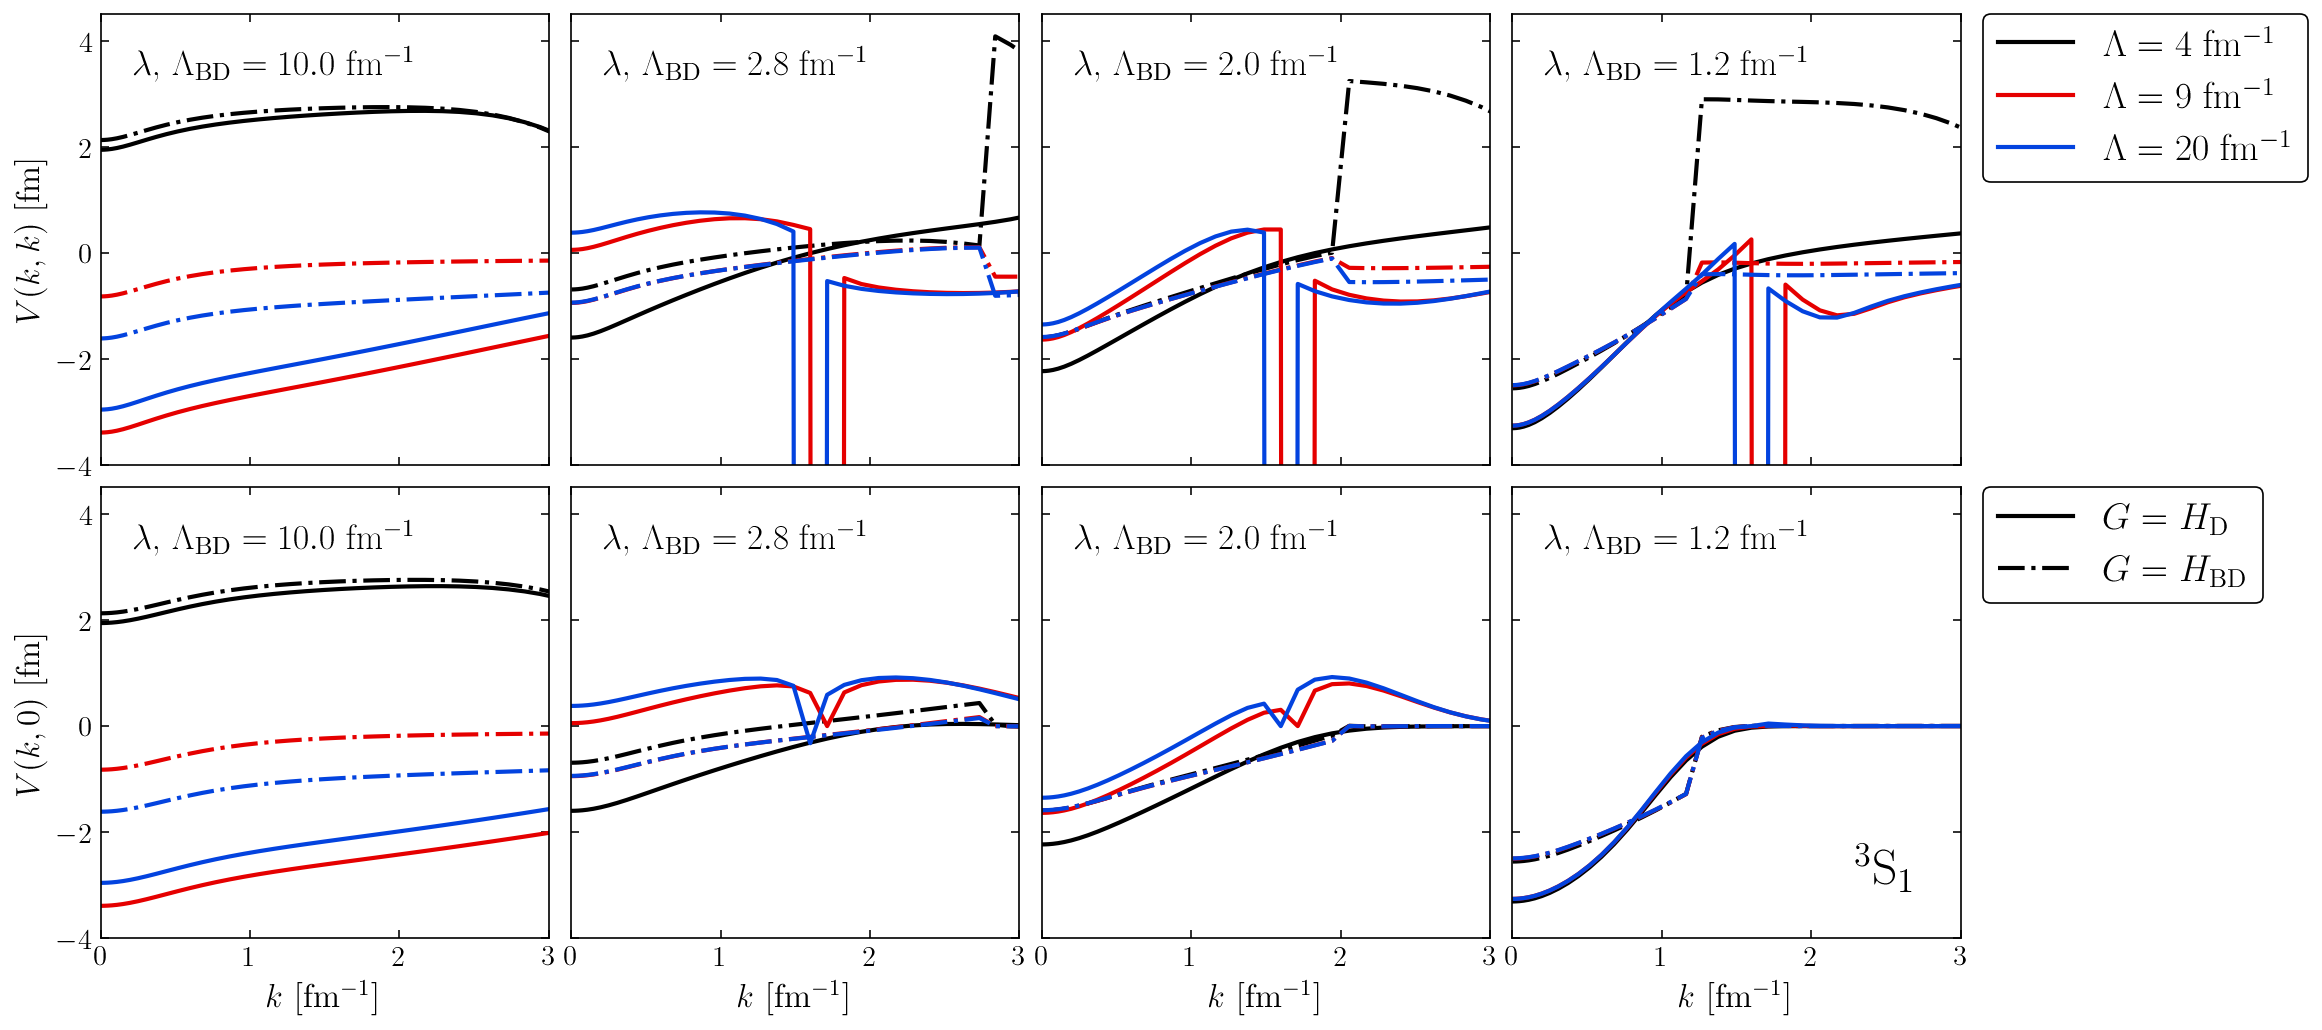

In [9]:
potential_slices_srg_only(kvnns, channel, kmax, kmid, ntot, generators,
                          lambdas, channel_label=True, save=True)

## Second set of figures

## Third set of figures

_Old stuff_

In [12]:
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values):
    """
    Plots SRG- and Magnus-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and
    far off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_values : tuple
        Tuple of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Consider only the 3S1 channel here
    channel = '3S1'
    
    # Load momentum
    k_array, _ = vnn.load_momentum(kvnn, channel)
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = 3.0
    xlim = (0.0, x_max)
    ylim = (-4.5, 2.5)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_diag_label = 'V(k,k) [fm]'
    y_off_diag_label = 'V(k,0) [fm]'
    y_label_size = 20
    y_stepsize = 1.0
    y_ticks = np.arange(ylim[0] + 0.5, ylim[1] + 0.5, y_stepsize)
    y_ticks_strings = ff.convert_ticks_to_labels(y_ticks)
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
        
        # Load SRG evolved potential
        if generator == 'Block-diag':
            # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
            V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lambda_array[-1],
                                          lambda_bd=lamb)
        else:
            V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
        # Store in dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_values:
            
            d[lamb][k_magnus] = {}
            
            # Load Magnus evolved potential
            if generator == 'Block-diag':
                # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                V_matrix = vnn.load_potential(kvnn, channel, method='magnus', generator=generator, 
                                              lamb=lambda_array[-1], lambda_bd=lamb, k_magnus=k_magnus, ds=ds)
            else:
                V_matrix = vnn.load_potential(kvnn, channel, method='magnus', generator=generator, lamb=lamb,
                                              k_magnus=k_magnus, ds=ds)
                
            # Store in dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop for diagonal and off-diagonals
    for i in range(2):
        
        if i == 0:
            slice_key = 'diag'
        else:
            slice_key = 'off-diag'
            
        # Loop over lambda's
        for j, lamb in enumerate(lambda_array):
            
            # Plot SRG-evolved potential slice first
            curve_color = 'xkcd:black'
            curve_style = 'dotted'
            curve_label = 'SRG'
            
            axs[i, j].plot(k_array, d[lamb]['SRG'][slice_key], color=curve_color, label=curve_label,
                           linestyle=curve_style, linewidth=curve_width)
            
            for m, k_magnus in enumerate(k_magnus_values):
                
                # Vary the curve color and style for k_magnus
                if m == 0:
                    curve_color = 'xkcd:blue'
                elif m == 1:
                    curve_color = 'xkcd:red'
                else:
                    curve_color = 'xkcd:green'
                curve_style = ff.line_styles(m)
                curve_label = r'$k_{\rm max}$' + '=%d' % k_magnus

                # Plot Magnus-evolved slice
                axs[i, j].plot(k_array, d[lamb][k_magnus][slice_key], color=curve_color, label=curve_label,
                               linestyle=curve_style, linewidth=curve_width)
                
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_strings)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks_strings)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size) 
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [13]:
# # Diagonal and far off-diagonal slices of the Wegner SRG- and Magnus-evolved kvnn = 901 potential in the 3S1 
# # channel

# kvnn = 901
# generator = 'Wegner'
# lambda_array = np.array( (10.0, 2.8, 2.0, 1.2) )
# k_magnus_values = (2, 6, 10)
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda labels to each sub-plot in the first row
# lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('figures/operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [14]:
# # Diagonal and far off-diagonal slices of the T_rel SRG- and Magnus-evolved kvnn = 901 potential in the 3S1 
# # channel

# kvnn = 901
# generator = 'T'
# lambda_array = np.array( (10.0, 2.8, 2.0, 1.2) )
# k_magnus_values = (2, 6, 10)
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda labels to each sub-plot in the first row
# lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('figures/operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)